In [137]:
# import the necessary packages
import os

import torch

# base path of the dataset
DATASET_PATH = os.path.join("dataset", "train")
# define the path to the images and masks dataset
IMAGE_DATASET_PATH = os.path.join(DATASET_PATH, "images")
MASK_DATASET_PATH = os.path.join(DATASET_PATH, "masks")
# define the test split
TEST_SPLIT = 0.15
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False
# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 1
NUM_CLASSES = 1
NUM_LEVELS = 3
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.0005
NUM_EPOCHS = 100
BATCH_SIZE = 64
# define the input image dimensions
INPUT_IMAGE_WIDTH = 128
INPUT_IMAGE_HEIGHT = 128
# define threshold to filter weak predictions
THRESHOLD = 0.5
# define the path to the base output directory
BASE_OUTPUT = "output"
# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_tgs_salt.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

In [138]:
import os
import time

import cv2
import einops
import matplotlib.pyplot as plt
import numpy as np
import torch
from model import UNet
from sklearn.model_selection import train_test_split
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as xfmrs
from tqdm import tqdm

In [139]:
torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))

device 0 NVIDIA GeForce RTX 3090


In [4]:
len(np.load("ct2019.npy"))

2329

In [140]:
class SegmentationDataset(Dataset):
    def __init__(self, imagePath, maskPath, start=0, end=2329, hu1=-900, hu2=100, xfmr=xfmrs.ToTensor(), xfmr_img=None):
        # store the image and mask filepaths, and augmentation
        # transforms
        self.imagePath = imagePath
        self.maskPath = maskPath
        self.xfmr = xfmr
        self.xfmri = xfmr_img
        self.start = start
        self.end = end
        self.hu1 = hu1
        self.hu2 = hu2

        self.imgs = np.load(self.imagePath)
        self.masks = np.load(self.maskPath)

    def __len__(self):
        # return the number of total samples contained in the dataset
        return self.end - self.start

    def __getitem__(self, idx):
        img = (self.imgs[idx + self.start][0].clip(self.hu1, self.hu2) - self.hu1) / (self.hu2 - self.hu1)
        mask = self.masks[idx + self.start][0]
        # apply the transformations to both image and its mask
        seed = torch.random.seed()

        torch.random.manual_seed(seed)
        img = self.xfmr(img.astype(np.float32))

        torch.random.manual_seed(seed)
        mask = self.xfmr(mask.astype(np.float32))

        if self.xfmri is not None:
            img = self.xfmri(img)
        # return a tuple of the image and its mask
        return (img, mask)

torch.Size([64, 1, 224, 224]) torch.Size([64, 1, 224, 224])


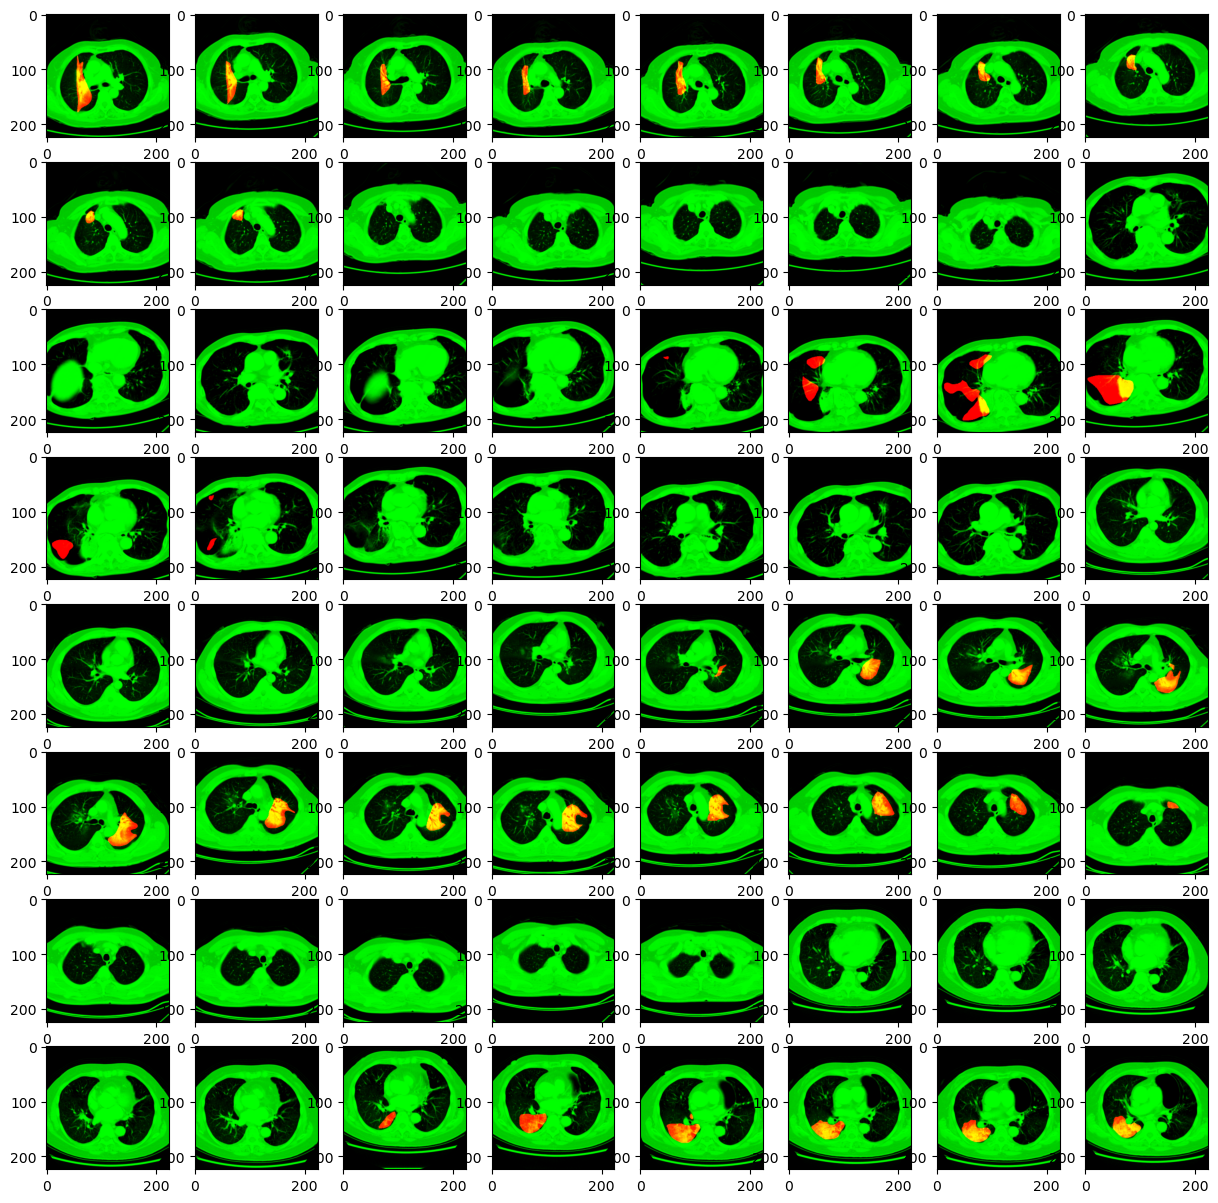

In [13]:
tds = SegmentationDataset(
    imagePath="ct2019.npy",
    maskPath="mask2019.npy",
    start=0,
    end=2000,
    hu1=-900,
    hu2=100,
    xfmr=xfmrs.Compose([xfmrs.ToTensor(), xfmrs.Resize((256, 256)), xfmrs.RandomCrop((224, 224))]),
    xfmr_img=xfmrs.Compose([xfmrs.Normalize(0.5, 0.5)]),
)
tdl = DataLoader(tds, batch_size=16, shuffle=True)

vds = SegmentationDataset(
    imagePath="ct2019.npy",
    maskPath="mask2019.npy",
    start=2000,
    end=2329,
    hu1=-900,
    hu2=100,
    xfmr=xfmrs.Compose([xfmrs.ToTensor(), xfmrs.Resize((256, 256)), xfmrs.RandomCrop((224, 224))]),
    xfmr_img=xfmrs.Compose([xfmrs.Normalize(0.5, 0.5)]),
)
vdl = DataLoader(vds, batch_size=BATCH_SIZE, shuffle=False)

for i, (imgs, masks) in enumerate(vdl):
    print(imgs.shape, masks.shape)
    plt.figure(figsize=(15, 15))
    for ii, (img, mask) in enumerate(zip(imgs, masks)):

        plt.subplot(8, 8, ii + 1)
        plt.imshow(
            einops.rearrange(np.array([mask.numpy()[0], img.numpy()[0] / 2 + 0.5, np.zeros((224, 224))]), "c h w -> h w c")
        )
    break

In [141]:
# initialize our UNet model
unet = UNet(encChannels=(1, 16, 32, 64, 128), decChannels=(128, 64, 32, 16), outSize=(224, 224)).to(device)
# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=INIT_LR)
# calculate steps per epoch for training and test set
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [142]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
e_bar = tqdm(range(NUM_EPOCHS))
for e in e_bar:
    # set the model in training mode
    unet.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalTestLoss = 0
    # loop over the training set
    for (i, (x, y)) in enumerate(tdl):
        # send the input to the device
        (x, y) = (x.to(device), y.to(device))
        # perform a forward pass and calculate the training loss
        pred = unet(x)
        loss = lossFunc(pred, y)
        # first, zero out any previously accumulated gradients, then
        # perform backpropagation, and then update model parameters
        opt.zero_grad()
        loss.backward()
        opt.step()
        # add the loss to the total training loss so far
        totalTrainLoss += loss
    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        unet.eval()
        # loop over the validation set
        for (x, y) in vdl:
            # send the input to the device
            (x, y) = (x.to(device), y.to(device))
            # make the predictions and calculate the validation loss
            pred = unet(x)
            totalTestLoss += lossFunc(pred, y)
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / len(tdl)
    avgTestLoss = totalTestLoss / len(vdl)
    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
    # print the model training and validation information
    e_bar.set_description(f"#{e+1:03}, tl:{avgTrainLoss:.4f}, vl:{avgTestLoss:.4f}")
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...


#100, tl:0.0225, vl:0.0315: 100%|█████████████████████████████████████████████████████| 100/100 [10:27<00:00,  6.28s/it]

[INFO] total time taken to train the model: 627.53s


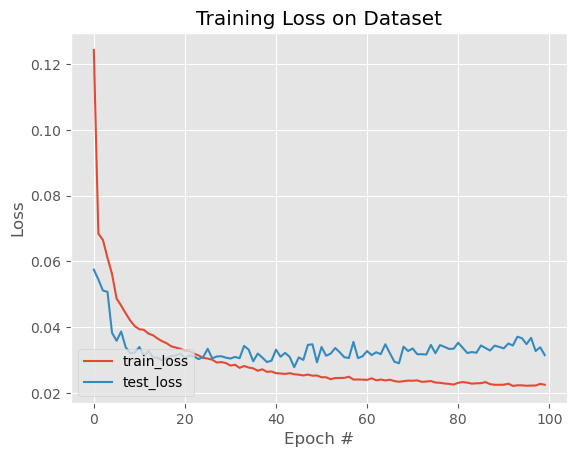

In [143]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("exp4.png")
# serialize the model to disk
torch.save(unet, "exp4.pth")

In [149]:
# eval
th = -.48
totalTestLoss, dices, ious = 0, 0, 0
best = []
with torch.no_grad():
    # set the model in evaluation mode
    unet.eval()
    # loop over the validation set
    for (x, y) in vdl:
        # send the input to the device
        (x, y) = (x.to(device), y.to(device))
        # make the predictions and calculate the validation loss
        pred = unet(x)
        totalTestLoss += lossFunc(pred, y)
        # plt.figure(figsize=(15, 15))
        for ii, (xx, yy, pp) in enumerate(zip(x.cpu().numpy(), y.cpu().numpy(), pred.cpu().numpy())):

            dice = (np.sum(yy[[pp[0] > th]]) + 0.1) / ((np.sum(yy[0]) + np.sum(pp[0] > th)) + 0.1)
            iou = (dice + 0.001) / (2.001 - dice)

            dices += dice
            ious += iou
            
            if (len(best) < 5 or best[-1][0] < iou) and iou != 1:
                best.append([iou, dice, xx, yy, pp])
                best = sorted(best, key=lambda x:x[0], reverse=True)
                if len(best) > 5:
                    best.pop()

            # plt.subplot(8, 8, ii + 1)
            # plt.imshow(
            #     einops.rearrange(
            #         np.array([yy[0] + xx[0] / 2 + 0.5, xx[0] / 2 + 0.5, (pp[0] > th) + xx[0] / 2 + 0.5]), "c h w -> h w c"
            #     )
            # )
            # plt.title(f"D{dice:.2f}, I{iou:.2f}")
            # plt.axis("off")
            # print(np.min(xx), np.max(xx), np.min(yy), np.max(yy), np.min(pp), np.max(pp) )
        # break
print(f"avg Dice = {dices/len(vds):.4f}, avg IoU = {ious/len(vds):.4f}, Valid Loss = {totalTestLoss/len(vdl):.4f}, ")

avg Dice = 0.4766, avg IoU = 0.4379, Valid Loss = 0.0315, 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


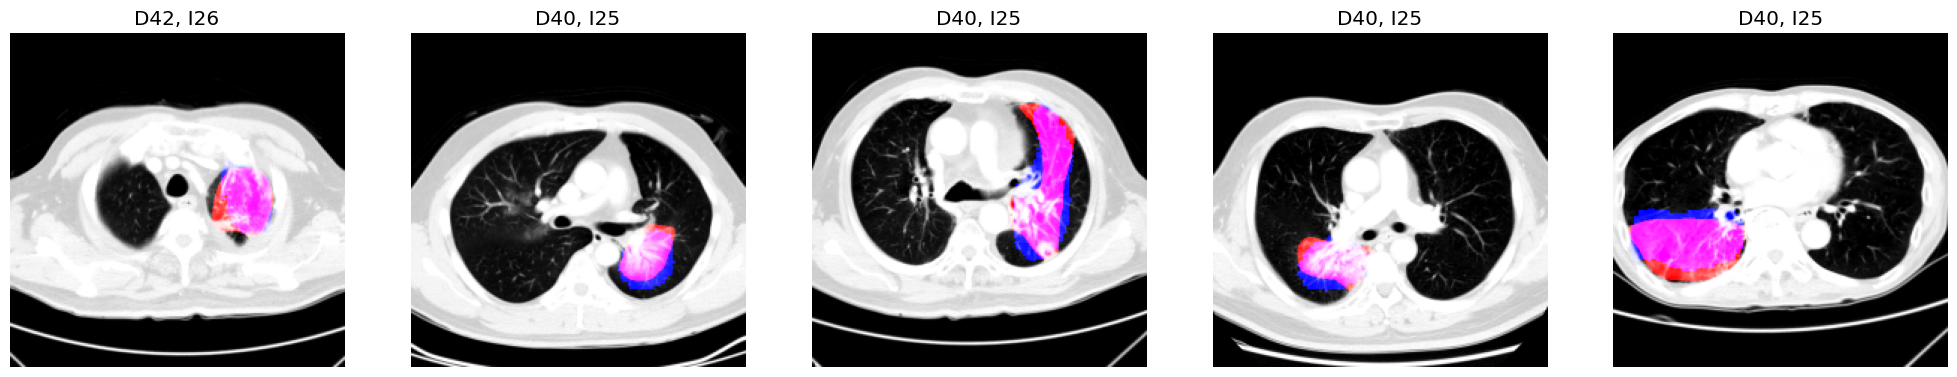

In [153]:
plt.figure(figsize=(25, 5))
for ii, (i, d, xxx, yyy, ppp) in enumerate(best):
    plt.subplot(1, 5, ii + 1)
    plt.imshow(
        einops.rearrange(np.array([yyy[0] + xxx[0] / 2 + 0.5, xxx[0] / 2 + 0.5, (ppp[0] > th) + xxx[0] / 2 + 0.5]), "c h w -> h w c")
    )
    plt.title(f"D{d*100:.0f}, I{i*100:.0f}")
    plt.axis("off")
    
plt.savefig("exp4_b.png")
plt.show()

In [134]:
c1, c2 = 43, 46
th = -.48
plt.figure(figsize=(15, 5))
for ii, (xx, yy, pp) in enumerate(zip(x.cpu().numpy()[c1:c2], y.cpu().numpy()[c1:c2], pred.cpu().numpy()[c1:c2])):

    dice = (np.sum(yy[[pp[0] > th]]) + 0.1) / ((np.sum(yy[0]) + np.sum(pp[0] > th)) + 0.1)
    iou = (dice + 0.001) / (2.001 - dice)

    dices += dice
    ious += iou

    plt.subplot(1, 3, ii + 1)
    plt.imshow(
        einops.rearrange(np.array([yy[0] + xx[0] / 2 + 0.5, xx[0] / 2 + 0.5, (pp[0] > th) + xx[0] / 2 + 0.5]), "c h w -> h w c")
    )
    plt.title(f"D{dice:.2f}, I{iou:.2f}")
    plt.axis("off")
plt.show()

<Figure size 1500x500 with 0 Axes>

max dice = (-0.48, 0.36), max iou = (-0.48, 0.22)


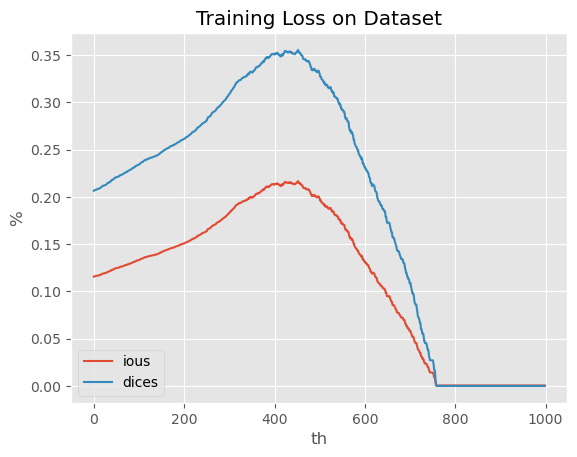

In [147]:
s_dice, s_iou = [], []
gg = 43
yc = y.cpu().numpy()
predc = pred.cpu().numpy()
for i in range(1, 1000):
    th = i * 0.01 - 5
    s_dice.append((np.sum(yc[gg][[predc[gg][0] > th]]) + 0.1) / ((np.sum(yc[gg][0]) + np.sum(predc[gg][0] > th)) + 0.1))
    s_iou.append((s_dice[-1] + 0.001) / (2.001 - s_dice[-1]))

plt.style.use("ggplot")
plt.figure()
plt.plot(s_iou, label="ious")
plt.plot(s_dice, label="dices")
plt.title("Training Loss on Dataset")
plt.xlabel("th")
plt.ylabel("%")
plt.legend(loc="lower left")

print(
    f"max dice = ({s_dice.index(np.max(s_dice))*0.01-5:.2f}, {np.max(s_dice):.2f}), max iou = ({s_iou.index(np.max(s_iou))*0.01-5:.2f}, {np.max(s_iou):.2f})"
)